In [ ]:
# Создания таблицы в базе данных SQLite и импорта данных из CSV файла

In [2]:
import sqlite3
import pandas as pd
import os

# Загружаем данные из CSV
df = pd.read_csv("retail_sales_dataset.csv")
print(f"Загружено {len(df)} записей из CSV")

# Создаем базу данных
db_path = "retail_sales.db"
if os.path.exists(db_path):
    os.remove(db_path)

conn = sqlite3.connect(db_path)

# Сохраняем DataFrame в SQLite таблицу
# pandas автоматически определит типы данных
df.to_sql('retail_sales', conn, if_exists='replace', index=False)

# Проверяем результат
cursor = conn.cursor()
cursor.execute("SELECT name, type FROM pragma_table_info('retail_sales')")
columns = cursor.fetchall()

print("\nСоздана таблица retail_sales с колонками:")
for col in columns:
    print(f"  - {col[0]}: {col[1]}")

cursor.execute("SELECT COUNT(*) FROM retail_sales")
count = cursor.fetchone()[0]
print(f"\nИмпортировано записей: {count}")

# Показываем пример данных
cursor.execute("SELECT * FROM retail_sales LIMIT 3")
samples = cursor.fetchall()
print("\nПримеры данных:")
for sample in samples:
    print(sample)

conn.close()
print(f"\nБаза данных сохранена: {db_path}")

Загружено 1000 записей из CSV

Создана таблица retail_sales с колонками:
  - Transaction ID: INTEGER
  - Date: TEXT
  - Customer ID: TEXT
  - Gender: TEXT
  - Age: INTEGER
  - Product Category: TEXT
  - Quantity: INTEGER
  - Price per Unit: INTEGER
  - Total Amount: INTEGER

Импортировано записей: 1000

Примеры данных:
(1, '2023-11-24', 'CUST001', 'Male', 34, 'Beauty', 3, 50, 150)
(2, '2023-02-27', 'CUST002', 'Female', 26, 'Clothing', 2, 500, 1000)
(3, '2023-01-13', 'CUST003', 'Male', 50, 'Electronics', 1, 30, 30)

База данных сохранена: retail_sales.db


In [ ]:
# SQL-запросы для извлечения и агрегации данных из таблицы

In [1]:
import sqlite3
import pandas as pd


def execute_sql_queries(db_file_path='retail_sales.db'):
    """Выполнение SQL-запросов для анализа данных"""

    conn = sqlite3.connect(db_file_path)

    # 1. Базовые запросы с фильтрацией WHERE
    print("=" * 80)
    print("1. БАЗОВЫЕ ЗАПРОСЫ С ФИЛЬТРАЦИЕЙ")
    print("=" * 80)

    # 1.1 Продажи для женщин старше 30 лет
    query1 = """
    SELECT customer_id, age, product_category, total_amount
    FROM retail_sales
    WHERE gender = 'Female' AND age > 30
    ORDER BY total_amount DESC
    LIMIT 10;
    """
    df1 = pd.read_sql_query(query1, conn)
    print("\n1.1 Топ-10 продаж (женщины старше 30 лет):")
    print(df1)

    # 1.2 Продажи в категории Electronics с высокой стоимостью
    query2 = """
    SELECT date, customer_id, age, gender, quantity, total_amount
    FROM retail_sales
    WHERE product_category = 'Electronics' AND total_amount > 1000
    ORDER BY total_amount DESC;
    """
    df2 = pd.read_sql_query(query2, conn)
    print(f"\n1.2 Продажи Electronics > 1000 (всего {len(df2)} записей):")
    print(df2.head())

    # 1.3 Продажи за последний квартал 2023 года
    query3 = """
    SELECT date, product_category, gender, total_amount
    FROM retail_sales
    WHERE date BETWEEN '2023-10-01' AND '2023-12-31'
    ORDER BY date;
    """
    df3 = pd.read_sql_query(query3, conn)
    print(f"\n1.3 Продажи в 4-м квартале 2023 (всего {len(df3)} записей):")
    print(df3.head())

    # 2. АГРЕГАТНЫЕ ФУНКЦИИ
    print("\n" + "=" * 80)
    print("2. АГРЕГАТНЫЕ ФУНКЦИИ")
    print("=" * 80)

    # 2.1 Продажи по возрасту и полу
    query4 = """
    SELECT
        CASE
            WHEN age BETWEEN 18 AND 25 THEN '18-25'
            WHEN age BETWEEN 26 AND 35 THEN '26-35'
            WHEN age BETWEEN 36 AND 45 THEN '36-45'
            WHEN age BETWEEN 46 AND 55 THEN '46-55'
            ELSE '55+'
        END as age_group,
        gender,
        COUNT(*) as transaction_count,
        SUM(total_amount) as total_sales,
        AVG(total_amount) as avg_transaction_value,
        SUM(quantity) as total_items
    FROM retail_sales
    GROUP BY age_group, gender
    ORDER BY age_group, gender;
    """
    df4 = pd.read_sql_query(query4, conn)
    print("\n2.1 Продажи по возрастным группам и полу:")
    print(df4)

    # 2.2 Продажи по полу в разрезе категорий
    query5 = """
    SELECT
        product_category,
        gender,
        COUNT(*) as transaction_count,
        SUM(total_amount) as total_sales,
        AVG(total_amount) as avg_sale,
        SUM(quantity) as total_quantity
    FROM retail_sales
    GROUP BY product_category, gender
    ORDER BY product_category, gender;
    """
    df5 = pd.read_sql_query(query5, conn)
    print("\n2.2 Продажи по полу в категориях:")
    print(df5)

    # 2.3 Динамика продаж по месяцам с разбивкой по полу
    query6 = """
    SELECT
        strftime('%Y-%m', date) as month,
        gender,
        COUNT(*) as transactions,
        SUM(total_amount) as monthly_sales,
        AVG(total_amount) as avg_transaction,
        SUM(quantity) as items_sold
    FROM retail_sales
    GROUP BY month, gender
    ORDER BY month, gender;
    """
    df6 = pd.read_sql_query(query6, conn)
    print("\n2.3 Динамика продаж по месяцам (по полу):")
    print(df6)

    # 3. ДОПОЛНИТЕЛЬНЫЕ АНАЛИТИЧЕСКИЕ ЗАПРОСЫ

    # 3.1 Корреляционный анализ (подготовка данных для матрицы)
    query7 = """
    SELECT
        age,
        CASE WHEN gender = 'Male' THEN 1 ELSE 0 END as is_male,
        quantity,
        price_per_unit,
        total_amount,
        CASE
            WHEN product_category = 'Electronics' THEN 1
            WHEN product_category = 'Clothing' THEN 2
            WHEN product_category = 'Beauty' THEN 3
        END as category_code
    FROM retail_sales;
    """
    df7 = pd.read_sql_query(query7, conn)
    print("\n3.1 Данные для корреляционной матрицы (первые 10 строк):")
    print(df7.head(10))

    # Корреляционная матрица
    print("\nКорреляционная матрица числовых признаков:")
    print(df7.corr().round(3))

    # 3.2 Сравнение по возрастным группам (вместо топ-10 клиентов)
    query8 = """
    WITH age_group_stats AS (
        SELECT
            CASE
                WHEN age BETWEEN 18 AND 25 THEN '18-25 (Молодежь)'
                WHEN age BETWEEN 26 AND 35 THEN '26-35 (Молодые взрослые)'
                WHEN age BETWEEN 36 AND 45 THEN '36-45 (Средний возраст)'
                WHEN age BETWEEN 46 AND 55 THEN '46-55 (Зрелые)'
                ELSE '55+ (Пенсионный)'
            END as age_group,
            COUNT(DISTINCT customer_id) as unique_customers,
            COUNT(*) as total_transactions,
            SUM(total_amount) as total_revenue,
            AVG(total_amount) as avg_transaction_value,
            SUM(quantity) as total_items,
            AVG(quantity) as avg_items_per_transaction,
            SUM(total_amount) / COUNT(DISTINCT customer_id) as revenue_per_customer
        FROM retail_sales
        GROUP BY age_group
    )
    SELECT
        age_group,
        unique_customers,
        total_transactions,
        ROUND(total_revenue, 2) as total_revenue,
        ROUND(avg_transaction_value, 2) as avg_transaction,
        total_items,
        ROUND(avg_items_per_transaction, 2) as avg_items,
        ROUND(revenue_per_customer, 2) as revenue_per_customer,
        ROUND(100.0 * total_transactions / SUM(total_transactions) OVER(), 2) as transactions_percentage
    FROM age_group_stats
    ORDER BY
        CASE age_group
            WHEN '18-25 (Молодежь)' THEN 1
            WHEN '26-35 (Молодые взрослые)' THEN 2
            WHEN '36-45 (Средний возраст)' THEN 3
            WHEN '46-55 (Зрелые)' THEN 4
            ELSE 5
        END;
    """
    df8 = pd.read_sql_query(query8, conn)
    print("\n3.2 Сравнение показателей по возрастным группам:")
    print(df8)

    # 3.3 Дополнительная визуализация: Анализ популярности категорий по возрастным группам
    query9 = """
    SELECT
        CASE
            WHEN age BETWEEN 18 AND 25 THEN '18-25'
            WHEN age BETWEEN 26 AND 35 THEN '26-35'
            WHEN age BETWEEN 36 AND 45 THEN '36-45'
            WHEN age BETWEEN 46 AND 55 THEN '46-55'
            ELSE '55+'
        END as age_group,
        product_category,
        COUNT(*) as purchases,
        SUM(total_amount) as category_revenue,
        AVG(total_amount) as avg_spent,
        SUM(quantity) as items_bought,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (PARTITION BY
            CASE
                WHEN age BETWEEN 18 AND 25 THEN '18-25'
                WHEN age BETWEEN 26 AND 35 THEN '26-35'
                WHEN age BETWEEN 36 AND 45 THEN '36-45'
                WHEN age BETWEEN 46 AND 55 THEN '46-55'
                ELSE '55+'
            END), 2) as category_percentage
    FROM retail_sales
    GROUP BY age_group, product_category
    ORDER BY age_group, category_revenue DESC;
    """
    df9 = pd.read_sql_query(query9, conn)
    print("\n3.3 Популярность категорий по возрастным группам:")
    print(df9)

    # 3.4 Сезонность продаж (по месяцам)
    query10 = """
    SELECT
        strftime('%m', date) as month_num,
        CASE strftime('%m', date)
            WHEN '01' THEN 'Январь'
            WHEN '02' THEN 'Февраль'
            WHEN '03' THEN 'Март'
            WHEN '04' THEN 'Апрель'
            WHEN '05' THEN 'Май'
            WHEN '06' THEN 'Июнь'
            WHEN '07' THEN 'Июль'
            WHEN '08' THEN 'Август'
            WHEN '09' THEN 'Сентябрь'
            WHEN '10' THEN 'Октябрь'
            WHEN '11' THEN 'Ноябрь'
            WHEN '12' THEN 'Декабрь'
        END as month_name,
        COUNT(*) as transactions,
        SUM(total_amount) as total_sales,
        AVG(total_amount) as avg_sale,
        SUM(quantity) as total_items,
        COUNT(DISTINCT customer_id) as unique_customers
    FROM retail_sales
    GROUP BY month_num
    ORDER BY month_num;
    """
    df10 = pd.read_sql_query(query10, conn)
    print("\n3.4 Сезонность продаж по месяцам:")
    print(df10)

    conn.close()

    # Возвращаем DataFrames для возможной визуализации
    return {
        'age_gender_sales': df4,
        'category_gender_sales': df5,
        'monthly_sales': df6,
        'correlation_data': df7,
        'age_group_comparison': df8,
        'category_by_age': df9,
        'seasonality': df10
    }


# Выполнение запросов
if __name__ == "__main__":
    results = execute_sql_queries()

    print("\n" + "=" * 80)
    print("АНАЛИТИЧЕСКИЕ ВЫВОДЫ:")
    print("=" * 80)

    # Краткая аналитика по возрастным группам
    print("\nКлючевые показатели по возрастным группам:")
    age_data = results['age_group_comparison']
    top_age_group = age_data.loc[age_data['total_revenue'].idxmax()]
    print(f"- Наибольшая выручка: {top_age_group['age_group']} - {top_age_group['total_revenue']:,.2f}")
    print(
        f"- Средний чек варьируется от {age_data['avg_transaction'].min():.2f} до {age_data['avg_transaction'].max():.2f}")

    # Анализ по категориям
    print("\nПопулярность категорий:")
    cat_data = results['category_by_age']
    for category in ['Electronics', 'Clothing', 'Beauty']:
        cat_revenue = cat_data[cat_data['product_category'] == category]['category_revenue'].sum()
        print(f"- {category}: {cat_revenue:,.2f}")

1. БАЗОВЫЕ ЗАПРОСЫ С ФИЛЬТРАЦИЕЙ

1.1 Топ-10 продаж (женщины старше 30 лет):
  customer_id  age product_category  total_amount
0     CUST015   42      Electronics        2000.0
1     CUST089   55      Electronics        2000.0
2     CUST093   35           Beauty        2000.0
3     CUST109   34      Electronics        2000.0
4     CUST253   53         Clothing        2000.0
5     CUST342   43         Clothing        2000.0
6     CUST480   42           Beauty        2000.0
7     CUST561   64         Clothing        2000.0
8     CUST592   46           Beauty        2000.0
9     CUST664   44         Clothing        2000.0

1.2 Продажи Electronics > 1000 (всего 53 записей):
         date customer_id  age  gender  quantity  total_amount
0  2023-01-16     CUST015   42  Female         4        2000.0
1  2023-12-05     CUST065   51    Male         4        2000.0
2  2023-05-23     CUST072   20  Female         4        2000.0
3  2023-10-01     CUST089   55  Female         4        2000.0
4  202

In [ ]:
# Визуализация

SQL ЗАПРОСЫ С ФИЛЬТРАЦИЕЙ

1. Топ-10 покупок женщин старше 50 лет:
  customer_id  age  gender product_category  total_amount
0     CUST089   55  Female      Electronics        2000.0
1     CUST253   53  Female         Clothing        2000.0
2     CUST561   64  Female         Clothing        2000.0
3     CUST735   64  Female         Clothing        2000.0
4     CUST789   61  Female         Clothing        2000.0
5     CUST875   51  Female      Electronics        2000.0
6     CUST144   59  Female           Beauty        1500.0
7     CUST313   55  Female           Beauty        1500.0
8     CUST463   54  Female           Beauty        1500.0
9     CUST608   55  Female      Electronics        1500.0

2. Покупки Electronics на сумму > 1000:
         date customer_id product_category  quantity  total_amount
0  2023-01-16     CUST015      Electronics         4        2000.0
1  2023-12-05     CUST065      Electronics         4        2000.0
2  2023-05-23     CUST072      Electronics         4 

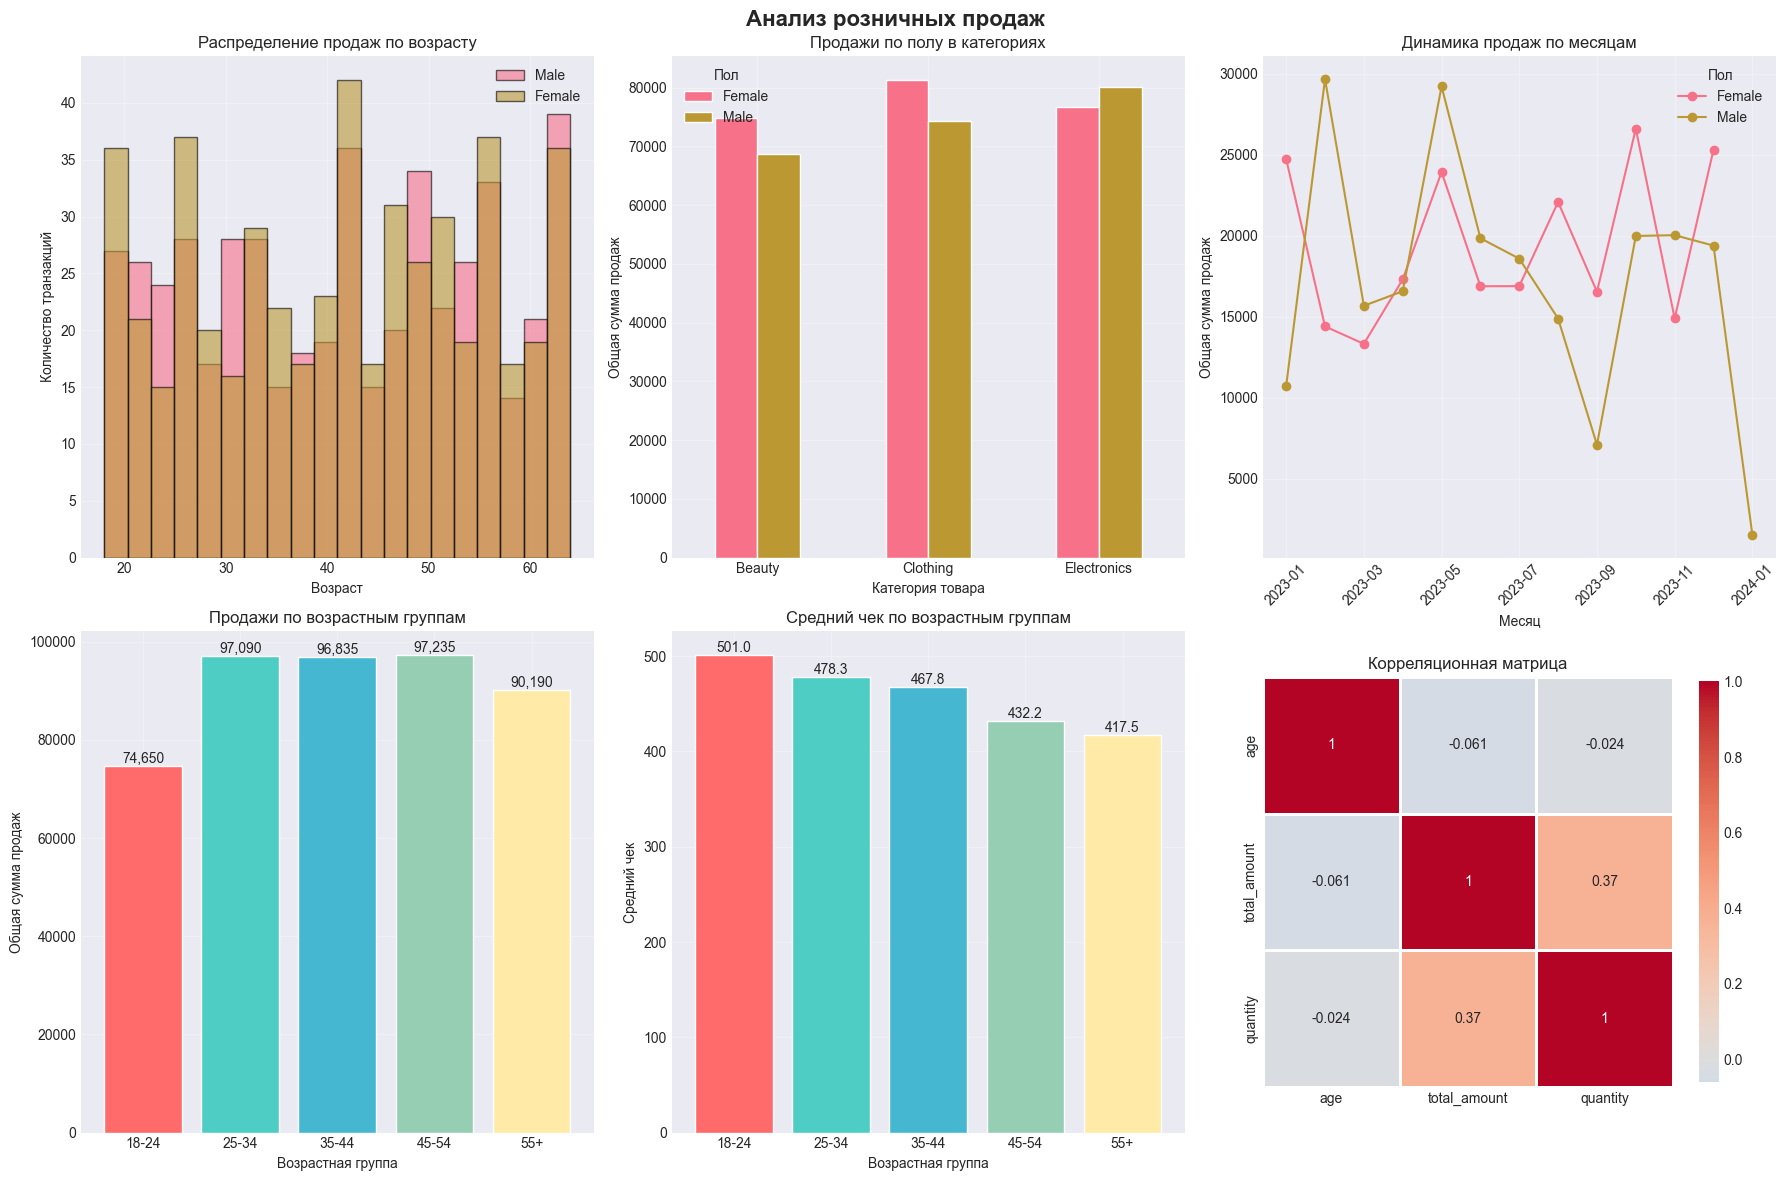

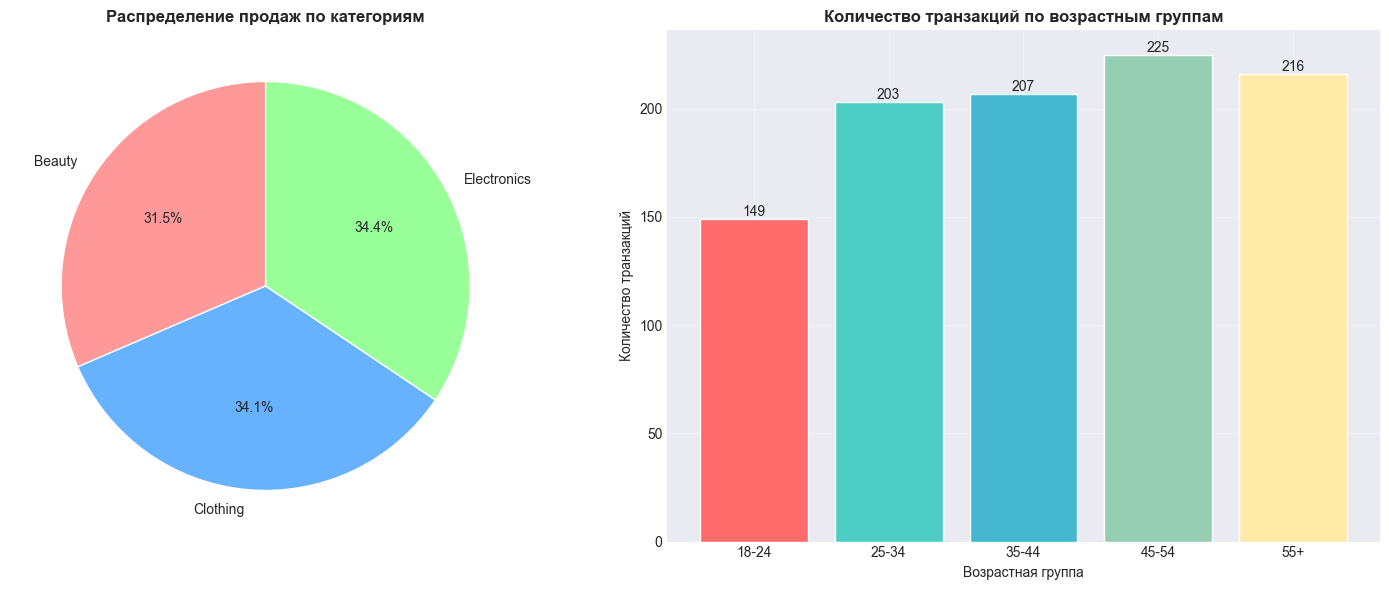


ГОТОВО!
Созданы файлы:
1. retail_sales_analysis.png - Основные графики
2. additional_analysis.png - Дополнительные графики
3. retail_sales_analysis.xlsx - Все данные в Excel


In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# Подключение к базе данных
conn = sqlite3.connect('retail_sales.db')

# 1. SQL запросы с условиями фильтрации
print("="*50)
print("SQL ЗАПРОСЫ С ФИЛЬТРАЦИЕЙ")
print("="*50)

# Запрос 1: Продажи для женщин старше 50 лет
query1 = """
SELECT customer_id, age, gender, product_category, total_amount
FROM retail_sales
WHERE gender = 'Female' AND age > 50
ORDER BY total_amount DESC
LIMIT 10
"""
df_female_over50 = pd.read_sql_query(query1, conn)
print("\n1. Топ-10 покупок женщин старше 50 лет:")
print(df_female_over50)

# Запрос 2: Покупки в категории Electronics с суммой больше 1000
query2 = """
SELECT date, customer_id, product_category, quantity, total_amount
FROM retail_sales
WHERE product_category = 'Electronics' AND total_amount > 1000
ORDER BY total_amount DESC
"""
df_electronics_high = pd.read_sql_query(query2, conn)
print("\n2. Покупки Electronics на сумму > 1000:")
print(df_electronics_high.head(10))

# Запрос 3: Молодые покупатели (18-25 лет) в категории Beauty
query3 = """
SELECT customer_id, age, gender, quantity, total_amount
FROM retail_sales
WHERE product_category = 'Beauty' AND age BETWEEN 18 AND 25
ORDER BY age
"""
df_beauty_young = pd.read_sql_query(query3, conn)
print("\n3. Молодые покупатели (18-25 лет) в категории Beauty:")
print(df_beauty_young.head(10))

# 2. SQL запросы с агрегатными функциями
print("\n" + "="*50)
print("АГРЕГАЦИОННЫЕ ЗАПРОСЫ")
print("="*50)

# Запрос 4: Статистика по возрасту и полу
query4 = """
SELECT
    gender,
    COUNT(*) as transaction_count,
    AVG(age) as avg_age,
    MIN(age) as min_age,
    MAX(age) as max_age,
    SUM(total_amount) as total_sales,
    AVG(total_amount) as avg_transaction
FROM retail_sales
GROUP BY gender
"""
df_age_gender_stats = pd.read_sql_query(query4, conn)
print("\n4. Статистика по полу:")
print(df_age_gender_stats)

# Запрос 5: Продажи по полу в категориях
query5 = """
SELECT
    product_category,
    gender,
    COUNT(*) as transactions,
    SUM(quantity) as total_items,
    SUM(total_amount) as total_sales,
    AVG(total_amount) as avg_transaction
FROM retail_sales
GROUP BY product_category, gender
ORDER BY product_category, gender
"""
df_category_gender = pd.read_sql_query(query5, conn)
print("\n5. Продажи по полу в категориях:")
print(df_category_gender)

# Запрос 6: Динамика продаж по месяцам
query6 = """
SELECT
    strftime('%Y-%m', date) as month,
    gender,
    COUNT(*) as transactions,
    SUM(total_amount) as total_sales,
    AVG(total_amount) as avg_sale
FROM retail_sales
GROUP BY month, gender
ORDER BY month
"""
df_monthly = pd.read_sql_query(query6, conn)
print("\n6. Динамика продаж по месяцам:")
print(df_monthly.head(15))

# Запрос 7: Сравнение по возрастным группам
query7 = """
SELECT
    CASE
        WHEN age < 25 THEN '18-24'
        WHEN age BETWEEN 25 AND 34 THEN '25-34'
        WHEN age BETWEEN 35 AND 44 THEN '35-44'
        WHEN age BETWEEN 45 AND 54 THEN '45-54'
        ELSE '55+'
    END as age_group,
    COUNT(*) as transaction_count,
    COUNT(DISTINCT customer_id) as unique_customers,
    SUM(total_amount) as total_sales,
    AVG(total_amount) as avg_transaction,
    SUM(quantity) as total_items,
    AVG(quantity) as avg_items
FROM retail_sales
GROUP BY age_group
ORDER BY
    CASE age_group
        WHEN '18-24' THEN 1
        WHEN '25-34' THEN 2
        WHEN '35-44' THEN 3
        WHEN '45-54' THEN 4
        ELSE 5
    END
"""
df_age_groups = pd.read_sql_query(query7, conn)
print("\n7. Сравнение по возрастным группам:")
print(df_age_groups)

# 3. ВИЗУАЛИЗАЦИЯ ДАННЫХ
print("\n" + "="*50)
print("СОЗДАНИЕ ВИЗУАЛИЗАЦИЙ")
print("="*50)

# Настройка стиля для всех графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. Продажи по возрасту и полу
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Анализ розничных продаж', fontsize=16, fontweight='bold')

# График 1: Распределение продаж по возрасту
df_all = pd.read_sql_query("SELECT age, gender, total_amount FROM retail_sales", conn)
for gender in df_all['gender'].unique():
    data = df_all[df_all['gender'] == gender]
    axes[0, 0].hist(data['age'], bins=20, alpha=0.6, label=gender, edgecolor='black')
axes[0, 0].set_xlabel('Возраст')
axes[0, 0].set_ylabel('Количество транзакций')
axes[0, 0].set_title('Распределение продаж по возрасту')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# График 2: Продажи по полу в категориях
df_cat = pd.read_sql_query("""
    SELECT product_category, gender, SUM(total_amount) as total_sales
    FROM retail_sales
    GROUP BY product_category, gender
""", conn)
pivot_cat = df_cat.pivot(index='product_category', columns='gender', values='total_sales')
pivot_cat.plot(kind='bar', ax=axes[0, 1], rot=0)
axes[0, 1].set_xlabel('Категория товара')
axes[0, 1].set_ylabel('Общая сумма продаж')
axes[0, 1].set_title('Продажи по полу в категориях')
axes[0, 1].legend(title='Пол')
axes[0, 1].grid(True, alpha=0.3)

# График 3: Динамика продаж по месяцам
df_monthly_pivot = df_monthly.pivot(index='month', columns='gender', values='total_sales')
df_monthly_pivot.plot(kind='line', marker='o', ax=axes[0, 2])
axes[0, 2].set_xlabel('Месяц')
axes[0, 2].set_ylabel('Общая сумма продаж')
axes[0, 2].set_title('Динамика продаж по месяцам')
axes[0, 2].legend(title='Пол')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3)

# График 4: Сравнение по возрастным группам
bars = axes[1, 0].bar(df_age_groups['age_group'], df_age_groups['total_sales'],
                      color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
axes[1, 0].set_xlabel('Возрастная группа')
axes[1, 0].set_ylabel('Общая сумма продаж')
axes[1, 0].set_title('Продажи по возрастным группам')
for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:,.0f}', ha='center', va='bottom')
axes[1, 0].grid(True, alpha=0.3)

# График 5: Средний чек по возрастным группам
bars2 = axes[1, 1].bar(df_age_groups['age_group'], df_age_groups['avg_transaction'],
                       color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
axes[1, 1].set_xlabel('Возрастная группа')
axes[1, 1].set_ylabel('Средний чек')
axes[1, 1].set_title('Средний чек по возрастным группам')
for bar in bars2:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}', ha='center', va='bottom')
axes[1, 1].grid(True, alpha=0.3)

# График 6: Корреляционная матрица
df_corr = df_all[['age', 'total_amount']].copy()
df_corr['quantity'] = pd.read_sql_query("SELECT quantity FROM retail_sales", conn)['quantity']
corr_matrix = df_corr.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, ax=axes[1, 2], linewidths=1, cbar_kws={"shrink": 0.8})
axes[1, 2].set_title('Корреляционная матрица')

plt.tight_layout()
plt.savefig('retail_sales_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Дополнительная визуализация: Топ продуктов по количеству продаж
fig2, axes2 = plt.subplots(1, 2, figsize=(15, 6))

# Круговая диаграмма распределения по категориям
df_category = pd.read_sql_query("""
    SELECT product_category, SUM(total_amount) as total_sales, COUNT(*) as transactions
    FROM retail_sales
    GROUP BY product_category
""", conn)

colors = ['#FF9999', '#66B2FF', '#99FF99']
axes2[0].pie(df_category['total_sales'], labels=df_category['product_category'],
             autopct='%1.1f%%', colors=colors, startangle=90)
axes2[0].set_title('Распределение продаж по категориям', fontweight='bold')

# Количество транзакций по возрастным группам
bars3 = axes2[1].bar(df_age_groups['age_group'], df_age_groups['transaction_count'],
                     color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
axes2[1].set_xlabel('Возрастная группа')
axes2[1].set_ylabel('Количество транзакций')
axes2[1].set_title('Количество транзакций по возрастным группам', fontweight='bold')
for bar in bars3:
    height = bar.get_height()
    axes2[1].text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}', ha='center', va='bottom')
axes2[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('additional_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Сохраняем все данные в Excel для дальнейшего анализа
with pd.ExcelWriter('retail_sales_analysis.xlsx', engine='openpyxl') as writer:
    df_female_over50.to_excel(writer, sheet_name='Женщины_50+', index=False)
    df_electronics_high.to_excel(writer, sheet_name='Electronics_1000+', index=False)
    df_beauty_young.to_excel(writer, sheet_name='Beauty_18-25', index=False)
    df_age_gender_stats.to_excel(writer, sheet_name='Статистика_по_полу', index=False)
    df_category_gender.to_excel(writer, sheet_name='Продажи_категории_пол', index=False)
    df_monthly.to_excel(writer, sheet_name='Динамика_помесячно', index=False)
    df_age_groups.to_excel(writer, sheet_name='Возрастные_группы', index=False)
    df_category.to_excel(writer, sheet_name='По_категориям', index=False)

print("\n" + "="*50)
print("ГОТОВО!")
print("="*50)
print("Созданы файлы:")
print("1. retail_sales_analysis.png - Основные графики")
print("2. additional_analysis.png - Дополнительные графики")
print("3. retail_sales_analysis.xlsx - Все данные в Excel")

# Закрываем соединение с базой данных
conn.close()